In [4]:
import imageio
import numpy as np
from scipy import signal
from numpy.lib.stride_tricks import as_strided as ast
import tqdm
import os
from multiprocessing import Pool
import matplotlib.pyplot as plt
import random
import albumentations as A
from glob import glob
from shutil import copyfile

In [2]:
'''
Source https://github.com/mubeta06/python/blob/master/signal_processing/sp/ssim.py
'''
def fspecial_gauss(size, sigma):
    """
        Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

def ssim(img1, img2, max_value, L, cs_map=False):
    """Return the Structural Similarity Map corresponding to input images img1 
    and img2 (images are assumed to be uint8)
    
    This function attempts to mimic precisely the functionality of ssim.m a 
    MATLAB provided by the author's of SSIM
    https://ece.uwaterloo.ca/~z70wang/research/ssim/ssim_index.m
    """
    #range [0,1]
    img1 = img1.astype(np.float64) / max_value
    img2 = img2.astype(np.float64) / max_value
    size = 11
    sigma = 1.5
    window = fspecial_gauss(size, sigma)
    K1 = 0.01
    K2 = 0.03
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = signal.fftconvolve(window, img1, mode='valid')
    mu2 = signal.fftconvolve(window, img2, mode='valid')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = signal.fftconvolve(window, img1*img1, mode='valid') - mu1_sq
    sigma2_sq = signal.fftconvolve(window, img2*img2, mode='valid') - mu2_sq
    sigma12 = signal.fftconvolve(window, img1*img2, mode='valid') - mu1_mu2
    if cs_map:
        return (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)), 
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        return ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))
    

In [3]:
'''
Source: https://stackoverflow.com/a/25174906
'''
def norm_shape(shape):
    '''
    Normalize numpy array shapes so they're always expressed as a tuple, 
    even for one-dimensional shapes.

    Parameters
        shape - an int, or a tuple of ints

    Returns
        a shape tuple
    '''
    try:
        i = int(shape)
        return (i,)
    except TypeError:
        # shape was not a number
        pass

    try:
        t = tuple(shape)
        return t
    except TypeError:
        # shape was not iterable
        pass

    raise TypeError('shape must be an int, or a tuple of ints')


def sliding_window(a,ws,ss = None,flatten = False):
    '''
    Return a sliding window over a in any number of dimensions

    Parameters:
        a  - an n-dimensional numpy array
        ws - an int (a is 1D) or tuple (a is 2D or greater) representing the size 
             of each dimension of the window
        ss - an int (a is 1D) or tuple (a is 2D or greater) representing the 
             amount to slide the window in each dimension. If not specified, it
             defaults to ws.
        flatten - if True, all slices are flattened, otherwise, there is an 
                  extra dimension for each dimension of the input.

    Returns
        an array containing each n-dimensional window from a

    from http://www.johnvinyard.com/blog/?p=268
    '''

    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)

    # convert ws, ss, and a.shape to numpy arrays so that we can do math in every 
    # dimension at once.
    ws = np.array(ws)
    ss = np.array(ss)
    shape = np.array(a.shape)


    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shape),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shape):
        raise ValueError('ws cannot be larger than a in any dimension. a.shape was %s and ws was %s' % (str(a.shape),str(ws)))

    # how many slices will there be in each dimension?
    newshape = norm_shape(((shape - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    strided = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return strided

    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    # remove any dimensions with size 1
    dim = filter(lambda i : i != 1,dim)
    return strided.reshape(dim)

### To control directory for saving patches change save_path in the function definition, max_value - maximum depth value, h_val - depth value(eq. or less) are taken as missing values, L - maximum value for SSIM calculation, we normalize depth in range [0,1], so L=1. save_path directory must contain: 'img', 'raw', 'render', 'hr' subdirectories

In [4]:
def max_val_ssim_filter(fname, max_value=5100., L=1., h_val=10, sourse_path='/all_data/hdd/un_depth/Scannet_all_data/', save_path='/all_data/hdd/un_depth/Scannet_ssim/'):
    
    depth_lq = imageio.imread(os.path.join(sourse_path, 'raw', fname))
    depth_sr = imageio.imread(os.path.join(sourse_path, 'render', fname))
    H, W = depth_lq.shape
    H_sr, W_sr = depth_sr.shape
    
    fname_base, ext = os.path.splitext(fname)
    resize = A.Resize(height=H_sr, width=W_sr, p=1)
    img = imageio.imread(os.path.join(sourse_path, 'img', fname_base + '.jpg'))
    img = resize(image=img)['image']
    
    if (np.max(depth_lq) <= max_value) and (np.max(depth_sr) <= max_value):
        
        ssim_mtrx = ssim(depth_lq, depth_sr[0::2, 0::2], max_value, L)
        
        H_p, W_p = ssim_mtrx.shape
        assert ((H - H_p) % 2 == 0) and ((W - W_p) % 2 == 0) and ((H - H_p) // 2 == (W - W_p) // 2 ), 'check how fftconvolve produce valid mode'
        pad = (H - H_p) // 2        #valid mode don't return values influenced by zero-padding
        depth_sr = depth_sr[2*pad:-2*pad, 2*pad:-2*pad]
        img = img[2*pad:-2*pad, 2*pad:-2*pad, :]
        depth_lq = depth_lq[pad:-pad, pad:-pad]
    
        ssim_patch = sliding_window(ssim_mtrx, (320, 320), (64, 64))
        ssim_idx = ssim_patch.mean(axis=(2,3)) > 0.8
        n_ssim = ssim_idx.sum()

        if n_ssim > 0:
            
            depth_sr_patch = sliding_window(depth_sr, (640,640), (128,128))
            hole_idx = (depth_sr_patch <= h_val).sum(axis=(2,3)) == 0
            
            final_idx = hole_idx * ssim_idx
            n_good = final_idx.sum()
            if n_good > 0:
                patch_idx = np.argwhere(final_idx)
        
                depth_lq_patch = sliding_window(depth_lq, (320, 320), (64, 64))
                img_patch = sliding_window(img, (640,640,3), (128, 128, 1))
                
                depth_gt_good = depth_sr_patch[final_idx][:, 0::2, 0::2]
                depth_lq_good = depth_lq_patch[final_idx]
                img_good = img_patch[final_idx]
                depth_sr_good = depth_sr_patch[final_idx]
                for i in range(n_good):
                    imageio.imsave(os.path.join(save_path, 'img', '{}_{}_{}{}'.format(fname_base, patch_idx[i,0], patch_idx[i,1], ".jpg")), img_good[i,0])
                    imageio.imsave(os.path.join(save_path, 'raw', '{}_{}_{}{}'.format(fname_base, patch_idx[i,0], patch_idx[i,1], ext)), depth_lq_good[i])
                    imageio.imsave(os.path.join(save_path, 'render', '{}_{}_{}{}'.format(fname_base, patch_idx[i,0], patch_idx[i,1], ext)), depth_gt_good[i])
                    imageio.imsave(os.path.join(save_path, 'hr','{}_{}_{}{}'.format(fname_base, patch_idx[i,0], patch_idx[i,1], ext)), depth_sr_good[i])
            else:
                return
        else:
            return
    else:
         return   

### The source_path directory must contain three subdirectories raw - with depth data from ScanNet, render - depth data after BundleFusion, img - RGB data from ScanNet.

In [5]:
sourse_path = '/all_data/hdd/un_depth/Scannet_all_data/' 
fnames = sorted(os.listdir(os.path.join(sourse_path, 'raw')))
n_processes = 30
with Pool(n_processes) as p:   
    res = list(tqdm.tqdm(p.imap(func=max_val_ssim_filter, iterable=fnames), total=len(fnames)))

100%|██████████| 48556/48556 [1:14:10<00:00, 10.91it/s]  


In [2]:
path = '/all_data/hdd/un_depth/Scannet_ssim/'
img = sorted(os.listdir(os.path.join(path,'img')))

In [15]:
def count_env(files):
    count = {}
    for f in tqdm.tqdm(files):
        count[f.split("_")[0]] = count.get(f.split("_")[0], 0) + 1
    return count

In [16]:
count = count_env(img)

100%|██████████| 96744/96744 [00:00<00:00, 753078.48it/s]


In [17]:
len(count)

660

# Split val, test

In [18]:
def get_scene(count, n_get):
    n_test = 0
    scenes = []
    while n_test < n_get:
        scene, n = random.choice(list(count.items()))
        n_test += n
        scenes.append(scene)
        del count[scene]
    return scenes, count

### Get at least 15000 test patches

In [19]:
n_min = 15000
test_scene, count = get_scene(count, n_min)

In [20]:
len(test_scene)

100

In [21]:
len(count)

560

In [23]:
def mv_scene(fnames, scene, path, save_path):
    for f in tqdm.tqdm(fnames):
        if f.split("_")[0] in scene:
            name = f.split('.')[0]
            os.rename(os.path.join(path, 'img', name+'.jpg'), os.path.join(save_path, 'img', name+'.jpg'))
            os.rename(os.path.join(path, 'raw', name+'.png'), os.path.join(save_path, 'raw', name+'.png'))
            os.rename(os.path.join(path, 'render', name+'.png'), os.path.join(save_path, 'render', name+'.png'))
            os.rename(os.path.join(path, 'hr', name+'.png'), os.path.join(save_path, 'hr', name+'.png'))

In [24]:
test_path = '/all_data/hdd/un_depth/Scannet_ssim/test/'
mv_scene(img, test_scene, path, test_path)

100%|██████████| 96744/96744 [00:01<00:00, 60904.63it/s]


### Get at least 5000 validation patches

In [25]:
n_min = 5000
val_scene, count = get_scene(count, n_min)

In [26]:
len(val_scene)

26

In [27]:
len(count)

534

In [28]:
val_path = '/all_data/hdd/un_depth/Scannet_ssim/val/'
mv_scene(img, val_scene, path, val_path)

100%|██████████| 96744/96744 [00:00<00:00, 166317.21it/s]


In [29]:
np.save('./test_scene', np.array(test_scene))
np.save('./val_scene', np.array(val_scene))

# Train split

In [30]:
img = sorted(os.listdir(os.path.join(path,'img')))

In [31]:
count = count_env(img)
len(count)

100%|██████████| 76563/76563 [00:00<00:00, 683505.16it/s]


534

### Divide the train patches into almost equal parts

In [32]:
trainA_scene, count = get_scene(count, len(img)//2)

In [33]:
len(trainA_scene)

290

In [35]:
len(count)

244

In [36]:
train_A_path = '/all_data/hdd/un_depth/Scannet_ssim/trainA/'
mv_scene(img, trainA_scene, path, train_A_path)

100%|██████████| 76563/76563 [00:03<00:00, 20364.51it/s]


### The remaining directories ( img, raw, render , hr ) belongs to the train B part

# Resize img

In [2]:
path = '/all_data/hdd/un_depth/Scannet_all_data/'
img = sorted(os.listdir(os.path.join(path,'img')))

In [3]:
def resize_img(fname, sourse_path='/all_data/hdd/un_depth/Scannet_all_data/'):
    resize = A.Resize(height=960, width=1280, p=1)
    img = imageio.imread(os.path.join(sourse_path, 'img', fname))
    img = resize(image=img)['image']
    imageio.imsave(os.path.join(sourse_path, 'resize_img', fname), img)

In [4]:
n_processes = 30
with Pool(n_processes) as p:   
    res = list(tqdm.tqdm(p.imap(func=resize_img, iterable=img), total=len(img)))

100%|██████████| 48556/48556 [02:45<00:00, 293.47it/s]


# Copy full size for trainA

In [14]:
def cp_scene(fnames, scene, path, save_path):
    for f in tqdm.tqdm(fnames):
        name = f.split('.')[0]
        if name in scene:
            copyfile(os.path.join(path, 'resize_img', name+'.jpg'), os.path.join(save_path, 'img', name+'.jpg'))
            copyfile(os.path.join(path, 'raw', name+'.png'), os.path.join(save_path, 'raw', name+'.png'))

In [55]:
path = '/all_data/hdd/un_depth/Scannet_all_data/'
img = sorted(os.listdir(os.path.join(path,'resize_img')))
img_crop = sorted(os.listdir(os.path.join(train_A_path,'img'))

In [56]:
trainA_names = set()
for f in img_crop:
    trainA_names.add(f.split('.')[0][:-4])

In [57]:
len(trainA_names)

6221

In [59]:
cp_scene(img, trainA_names, path, os.path.join(train_A_path,'full_size'))

100%|██████████| 48556/48556 [00:02<00:00, 21441.99it/s]


# Copy full size for test

In [3]:
path = '/all_data/hdd/un_depth/Scannet_ssim/test'
img = sorted(os.listdir(os.path.join(path,'img')))

In [4]:
def count_frame(files):
    count = {}
    for f in tqdm.tqdm(files):
        count[f.split('.')[0][:-4]] = count.get(f.split('.')[0][:-4], 0) + 1
    return count

In [5]:
count = count_frame(img)

100%|██████████| 15123/15123 [00:00<00:00, 591851.11it/s]


In [6]:
def get_frame_npatch(count, n_patch):
    scene = []
    for k,v in count.items():
        if v >= n_patch:
            scene.append(k)
    return scene

In [8]:
scene_full_test = get_frame_npatch(count, 10)
len(scene_full_test)

559

In [7]:
def cp_frame(fnames, scene, path, save_path):
    for f in tqdm.tqdm(fnames):
        name = f.split('.')[0]
        if name in scene:
            copyfile(os.path.join(path, 'resize_img', name+'.jpg'), os.path.join(save_path, 'img', name+'.jpg'))
            copyfile(os.path.join(path, 'raw', name+'.png'), os.path.join(save_path, 'raw', name+'.png'))
            copyfile(os.path.join(path, 'render', name+'.png'), os.path.join(save_path, 'hr', name+'.png'))

In [8]:
path = '/all_data/hdd/un_depth/Scannet_all_data/'
img = sorted(os.listdir(os.path.join(path,'resize_img')))

In [9]:
cp_frame(img, scene_full_test, path,'/all_data/hdd/un_depth/Scannet_ssim/test/full_size/')

100%|██████████| 48556/48556 [00:00<00:00, 65979.21it/s]


In [10]:
import cv2
import glob
def hole_hist(depths):
    p_list_all = []
    for i in tqdm.tqdm(range(len(depths))):
        targ = imageio.imread(depths[i]).astype(np.float64)
        p = (np.sum(targ[50:-50, 50:-50] < 10) / (380 * 540)) * 100
        p_list_all.append(p)
    return p_list_all

# We manually selected full-size scenes corresponding to test patches with no misalignments and with the distribution of hole sizes in low-quality test frames similar to raw ScanNet. 

In [12]:
hist_train = hole_hist(glob.glob('/root/datasets/un_depth/Scannet_ssim/trainA/full_size/depth/*.png'))
test_hist = hole_hist(glob.glob('/root/datasets/un_depth/Scannet_ssim/testA/full_size/depth/*.png'))

100%|██████████| 501/501 [00:05<00:00, 92.18it/s] 


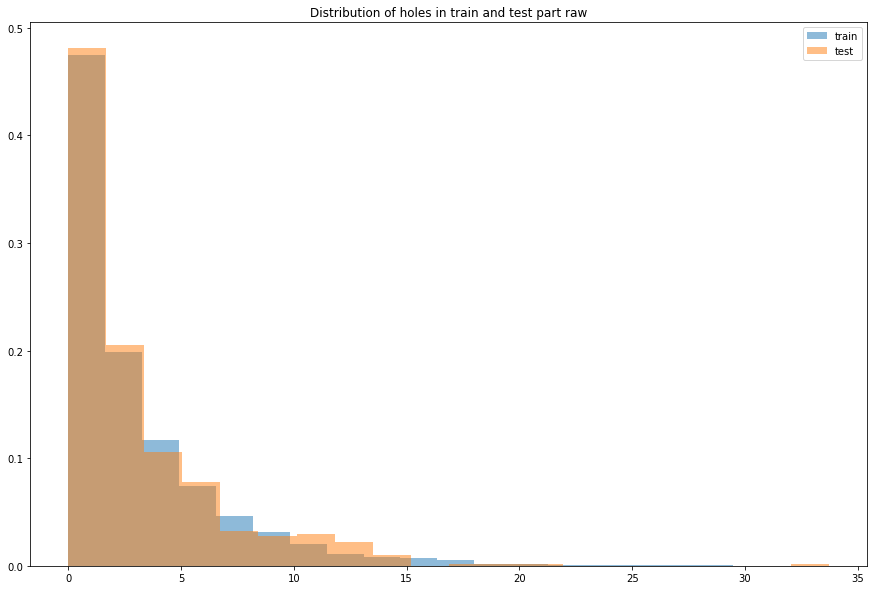

In [19]:
fig = plt.figure(figsize = (15,10))
plt.title('Distribution of holes in train and test part raw')
plt.hist(hist_train, bins=20, label = 'train',alpha=0.5, weights=np.ones(len(hist_train)) / len(hist_train))
plt.hist(test_hist, bins=20,label = 'test',alpha=0.5, weights=np.ones(len(test_hist)) / len(test_hist))
plt.legend(loc='upper right')
plt.show()

In [20]:
hist_train = hole_hist(glob.glob('/root/datasets/un_depth/Scannet_ssim/trainB/full_size/depth/*.png'))
test_hist = hole_hist(glob.glob('/root/datasets/un_depth/Scannet_ssim/testB/full_size/depth/*.png'))

100%|██████████| 501/501 [00:20<00:00, 24.35it/s]


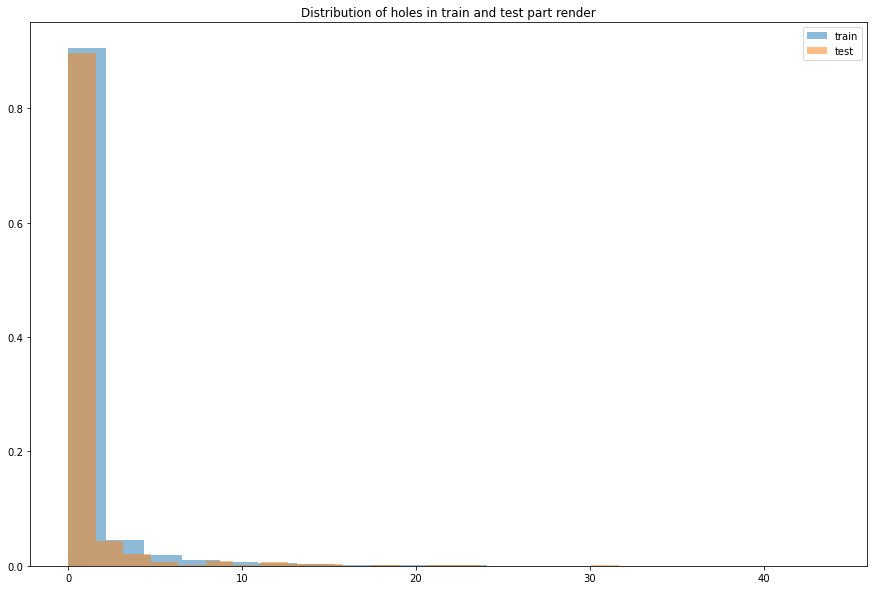

In [21]:
fig = plt.figure(figsize = (15,10))
plt.title('Distribution of holes in train and test part render')
plt.hist(hist_train, bins=20, label = 'train',alpha=0.5, weights=np.ones(len(hist_train)) / len(hist_train))
plt.hist(test_hist, bins=20,label = 'test',alpha=0.5, weights=np.ones(len(test_hist)) / len(test_hist))
plt.legend(loc='upper right')
plt.show()